# Segmenter
Author Paper: https://arxiv.org/abs/2105.05633

In [1]:
%pip install einops timm imutils torchvision lightning torchmetrics

  Preparing metadata (setup.py) ... - \ done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.2/43.2 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 808.5/808.5 kB 14.3 MB/s eta 0:00:00
  Created wheel for imutils: filename=imutils-0.5.4-py3-none-any.whl size=25834 sha256=c87d651c8182a9ecb030c761a791694163efb7848c866e1f0c40431e9e146df5
  Stored in directory: /root/.cache/pip/wheels/85/cf/3a/e265e975a1e7c7e54eb3692d6aa4e2e7d6a3945d29da46f2d7
Successfully built imutils
Note: you may need to restart the kernel to use updated packages.


# Segmenter implemtation
Implementation is adopted from https://github.com/rstrudel/segmenter/

## Block

In [2]:
"""
Adapted from 2020 Ross Wightman
https://github.com/rwightman/pytorch-image-models
"""

import torch.nn as nn
from einops import rearrange
from pathlib import Path
import torch.nn.functional as F
from timm.models.layers import DropPath
import torch


class FeedForward(nn.Module):
    def __init__(self, dim, hidden_dim, dropout, out_dim=None):
        super().__init__()
        self.fc1 = nn.Linear(dim, hidden_dim)
        self.act = nn.GELU()
        if out_dim is None:
            out_dim = dim
        self.fc2 = nn.Linear(hidden_dim, out_dim)
        self.drop = nn.Dropout(dropout)

    @property
    def unwrapped(self):
        return self

    def forward(self, x):
        x = self.fc1(x)
        x = self.act(x)
        x = self.drop(x)
        x = self.fc2(x)
        x = self.drop(x)
        return x

class Attention(nn.Module):
    def __init__(self, dim, heads, dropout):
        super().__init__()
        self.heads = heads
        head_dim = dim // heads
        self.scale = head_dim ** -0.5
        self.attn = None

        self.qkv = nn.Linear(dim, dim * 3)
        self.attn_drop = nn.Dropout(dropout)
        self.proj = nn.Linear(dim, dim)
        self.proj_drop = nn.Dropout(dropout)

    @property
    def unwrapped(self):
        return self

    def forward(self, x, mask=None):
        B, N, C = x.shape
        qkv = (
            self.qkv(x)
            .reshape(B, N, 3, self.heads, C // self.heads)
            .permute(2, 0, 3, 1, 4)
        )
        
        q, k, v = (
            qkv[0],
            qkv[1],
            qkv[2],
        )

        attn = (q @ k.transpose(-2, -1)) * self.scale
        attn = attn.softmax(dim=-1)
        attn = self.attn_drop(attn)
       

        x = (attn @ v).transpose(1, 2).reshape(B, N, C)
        x = self.proj(x)
        x = self.proj_drop(x)
    
        return x, attn

class Block(nn.Module):
    def __init__(self, dim, heads, mlp_dim, dropout, drop_path):
        super().__init__()
        self.norm1 = nn.LayerNorm(dim)
        self.norm2 = nn.LayerNorm(dim)
        self.attn = Attention(dim, heads, dropout)
        self.mlp = FeedForward(dim, mlp_dim, dropout)
        self.drop_path = DropPath(drop_path) if drop_path > 0.0 else nn.Identity()

    def forward(self, x, mask=None, return_attention=False):
        x = self.norm1(x)

        y, attn = self.attn(x, mask)
        if return_attention:
            return attn
        x = x + self.drop_path(y)
        x = x + self.drop_path(self.mlp(self.norm2(x)))
        
        return x

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math
from collections import defaultdict
from timm.models.layers import trunc_normal_

##### outer folder utility
import os
import torch
"""
GPU wrappers
"""

use_gpu = False
gpu_id = 0
device = None

distributed = False
dist_rank = 0
world_size = 1


def set_gpu_mode(mode):
    global use_gpu
    global device
    global gpu_id
    global distributed
    global dist_rank
    global world_size
    gpu_id = int(os.environ.get("SLURM_LOCALID", 0))
    dist_rank = int(os.environ.get("SLURM_PROCID", 0))
    world_size = int(os.environ.get("SLURM_NTASKS", 1))

    distributed = world_size > 1
    use_gpu = mode
    device = torch.device(f"cuda:{gpu_id}" if use_gpu else "cpu")
    torch.backends.cudnn.benchmark = True


def init_weights(m):
    if isinstance(m, nn.Linear):
        trunc_normal_(m.weight, std=0.02)
        if isinstance(m, nn.Linear) and m.bias is not None:
            nn.init.constant_(m.bias, 0)
    elif isinstance(m, nn.LayerNorm):
        nn.init.constant_(m.bias, 0)
        nn.init.constant_(m.weight, 1.0)


def resize_pos_embed(posemb, grid_old_shape, grid_new_shape, num_extra_tokens):
    # Rescale the grid of position embeddings when loading from state_dict. Adapted from
    # https://github.com/google-research/vision_transformer/blob/00883dd691c63a6830751563748663526e811cee/vit_jax/checkpoint.py#L224
    posemb_tok, posemb_grid = (
        posemb[:, :num_extra_tokens],
        posemb[0, num_extra_tokens:],
    )
    if grid_old_shape is None:
        gs_old_h = int(math.sqrt(len(posemb_grid)))
        gs_old_w = gs_old_h
    else:
        gs_old_h, gs_old_w = grid_old_shape

    gs_h, gs_w = grid_new_shape
    posemb_grid = posemb_grid.reshape(1, gs_old_h, gs_old_w, -1).permute(0, 3, 1, 2)
    posemb_grid = F.interpolate(posemb_grid, size=(gs_h, gs_w), mode="bilinear")
    posemb_grid = posemb_grid.permute(0, 2, 3, 1).reshape(1, gs_h * gs_w, -1)
    posemb = torch.cat([posemb_tok, posemb_grid], dim=1)
    return posemb


def checkpoint_filter_fn(state_dict, model):
    """ convert patch embedding weight from manual patchify + linear proj to conv"""
    out_dict = {}
    if "model" in state_dict:
        # For deit models
        state_dict = state_dict["model"]
    num_extra_tokens = 1 + ("dist_token" in state_dict.keys())
    patch_size = model.patch_size
    image_size = model.patch_embed.image_size
    for k, v in state_dict.items():
        if k == "pos_embed" and v.shape != model.pos_embed.shape:
            # To resize pos embedding when using model at different size from pretrained weights
            v = resize_pos_embed(
                v,
                None,
                (image_size[0] // patch_size, image_size[1] // patch_size),
                num_extra_tokens,
            )
        out_dict[k] = v
    return out_dict


def padding(im, patch_size, fill_value=0):
    # make the image sizes divisible by patch_size
    H, W = im.size(2), im.size(3)
    pad_h, pad_w = 0, 0
    if H % patch_size > 0:
        pad_h = patch_size - (H % patch_size)
    if W % patch_size > 0:
        pad_w = patch_size - (W % patch_size)
    im_padded = im
    if pad_h > 0 or pad_w > 0:
        im_padded = F.pad(im, (0, pad_w, 0, pad_h), value=fill_value)
    return im_padded


def unpadding(y, target_size):
    H, W = target_size
    H_pad, W_pad = y.size(2), y.size(3)
    # crop predictions on extra pixels coming from padding
    extra_h = H_pad - H
    extra_w = W_pad - W
    if extra_h > 0:
        y = y[:, :, :-extra_h]
    if extra_w > 0:
        y = y[:, :, :, :-extra_w]
    return y


def resize(im, smaller_size):
    h, w = im.shape[2:]
    if h < w:
        ratio = w / h
        h_res, w_res = smaller_size, ratio * smaller_size
    else:
        ratio = h / w
        h_res, w_res = ratio * smaller_size, smaller_size
    if min(h, w) < smaller_size:
        im_res = F.interpolate(im, (int(h_res), int(w_res)), mode="bilinear")
    else:
        im_res = im
    return im_res


def sliding_window(im, flip, window_size, window_stride):
    B, C, H, W = im.shape
    ws = window_size

    windows = {"crop": [], "anchors": []}
    h_anchors = torch.arange(0, H, window_stride)
    w_anchors = torch.arange(0, W, window_stride)
    h_anchors = [h.item() for h in h_anchors if h < H - ws] + [H - ws]
    w_anchors = [w.item() for w in w_anchors if w < W - ws] + [W - ws]
    for ha in h_anchors:
        for wa in w_anchors:
            window = im[:, :, ha : ha + ws, wa : wa + ws]
            windows["crop"].append(window)
            windows["anchors"].append((ha, wa))
    windows["flip"] = flip
    windows["shape"] = (H, W)
    return windows


def merge_windows(windows, window_size, ori_shape):
    ws = window_size
    im_windows = windows["seg_maps"]
    anchors = windows["anchors"]
    C = im_windows[0].shape[0]
    H, W = windows["shape"]
    flip = windows["flip"]

    logit = torch.zeros((C, H, W), device=im_windows.device)
    count = torch.zeros((1, H, W), device=im_windows.device)
    for window, (ha, wa) in zip(im_windows, anchors):
        logit[:, ha : ha + ws, wa : wa + ws] += window
        count[:, ha : ha + ws, wa : wa + ws] += 1
    logit = logit / count
    logit = F.interpolate(
        logit.unsqueeze(0),
        ori_shape,
        mode="bilinear",
    )[0]
    if flip:
        logit = torch.flip(logit, (2,))
    result = F.softmax(logit, 0)
    return result


def inference(
    model,
    ims,
    ims_metas,
    ori_shape,
    window_size,
    window_stride,
    batch_size,
):
    C = model.n_cls
    seg_map = torch.zeros((C, ori_shape[0], ori_shape[1]), device=device)
    for im, im_metas in zip(ims, ims_metas):
        im = im.to(device)
        im = resize(im, window_size)
        flip = im_metas["flip"]
        windows = sliding_window(im, flip, window_size, window_stride)
        crops = torch.stack(windows.pop("crop"))[:, 0]
        B = len(crops)
        WB = batch_size
        seg_maps = torch.zeros((B, C, window_size, window_size), device=im.device)
        with torch.no_grad():
            for i in range(0, B, WB):
                seg_maps[i : i + WB] = model.forward(crops[i : i + WB])
        windows["seg_maps"] = seg_maps
        im_seg_map = merge_windows(windows, window_size, ori_shape)
        seg_map += im_seg_map
    seg_map /= len(ims)
    return seg_map


def num_params(model):
    model_parameters = filter(lambda p: p.requires_grad, model.parameters())
    n_params = sum([torch.prod(torch.tensor(p.size())) for p in model_parameters])
    return n_params.item()

## Decoder

In [4]:
import torch
import torch.nn as nn
from einops import rearrange
from timm.models.layers import trunc_normal_

class DecoderLinear(nn.Module):
    def __init__(self, n_cls, patch_size, d_encoder):
        super().__init__()

        self.d_encoder = d_encoder
        self.patch_size = patch_size
        self.n_cls = n_cls

        self.head = nn.Linear(self.d_encoder, n_cls)
        self.apply(init_weights)

    @torch.jit.ignore
    def no_weight_decay(self):
        return set()

    def forward(self, x, im_size):
        H, W = im_size
        GS = H // self.patch_size
        x = self.head(x)
        ## h*w = n
        x = rearrange(x, "b (h w) c -> b c h w", h=GS)

        return x


class MaskTransformer(nn.Module):
    def __init__(
        self,
        n_cls,
        patch_size,
        d_encoder,
        n_layers,
        n_heads,
        d_model,
        d_ff,
        drop_path_rate,
        dropout,
    ):
        super().__init__()
        self.d_encoder = d_encoder # return by decode n x d
        self.patch_size = patch_size 
        self.n_layers = n_layers
        self.n_cls = n_cls
        self.d_model = d_model
        self.d_ff = d_ff
        self.scale = d_model ** -0.5 # attention

        dpr = [x.item() for x in torch.linspace(0, drop_path_rate, n_layers)]
        self.blocks = nn.ModuleList(
            [Block(d_model, n_heads, d_ff, dropout, dpr[i]) for i in range(n_layers)]
        )

        # initial class embedding randomly. Shape K x D_model. Parameter means learnable
        self.cls_emb = nn.Parameter(torch.randn(1, n_cls, d_model))
        # Projection: map D of encoder to D model
        self.proj_dec = nn.Linear(d_encoder, d_model)

        self.proj_patch = nn.Parameter(self.scale * torch.randn(d_model, d_model))
        self.proj_classes = nn.Parameter(self.scale * torch.randn(d_model, d_model))

        self.decoder_norm = nn.LayerNorm(d_model)
        self.mask_norm = nn.LayerNorm(n_cls)

        self.apply(init_weights)
        trunc_normal_(self.cls_emb, std=0.02)

    @torch.jit.ignore
    def no_weight_decay(self):
        return {"cls_emb"}
    
    def forward(self, x, im_size):
        H, W = im_size
        GS = H // self.patch_size

        x = self.proj_dec(x)
        cls_emb = self.cls_emb.expand(x.size(0), -1, -1)
        x = torch.cat((x, cls_emb), 1)
        for blk in self.blocks:
            x = blk(x)
        x = self.decoder_norm(x)

        patches, cls_seg_feat = x[:, : -self.n_cls], x[:, -self.n_cls :]
        patches = patches @ self.proj_patch
        cls_seg_feat = cls_seg_feat @ self.proj_classes

        patches = patches / patches.norm(dim=-1, keepdim=True)
        cls_seg_feat = cls_seg_feat / cls_seg_feat.norm(dim=-1, keepdim=True)

        masks = patches @ cls_seg_feat.transpose(1, 2)
        masks = self.mask_norm(masks)
        masks = rearrange(masks, "b (h w) n -> b n h w", h=int(GS))

        return masks

    def get_attention_map(self, x, layer_id):
        if layer_id >= self.n_layers or layer_id < 0:
            raise ValueError(
                f"Provided layer_id: {layer_id} is not valid. 0 <= {layer_id} < {self.n_layers}."
            )
        x = self.proj_dec(x)
        cls_emb = self.cls_emb.expand(x.size(0), -1, -1)
        x = torch.cat((x, cls_emb), 1)
        for i, blk in enumerate(self.blocks):
            if i < layer_id:
                x = blk(x)
            else:
                return blk(x, return_attention=True)

## Vision transformer

In [5]:
"""
Adapted from 2020 Ross Wightman
https://github.com/rwightman/pytorch-image-models
"""
import torch
import torch.nn as nn
from timm.models.layers import trunc_normal_
from timm.models.vision_transformer import _load_weights


class PatchEmbedding(nn.Module):
    def __init__(self, image_size, patch_size, embed_dim, channels):
        super().__init__()

        self.image_size = image_size
        if image_size[0] % patch_size != 0 or image_size[1] % patch_size != 0:
            raise ValueError("image dimensions must be divisible by the patch size")
        self.grid_size = image_size[0] // patch_size, image_size[1] // patch_size
        self.num_patches = self.grid_size[0] * self.grid_size[1]
        self.patch_size = patch_size

        self.proj = nn.Conv2d(
            channels, embed_dim, kernel_size=patch_size, stride=patch_size
        )

    def forward(self, im):
        B, C, H, W = im.shape
        x = self.proj(im).flatten(2).transpose(1, 2)
        return x


class VisionTransformer(nn.Module):
    def __init__(
        self,
        image_size,
        patch_size,
        n_layers,
        d_model,
        d_ff,
        n_heads,
        n_cls,
        dropout=0.1,
        drop_path_rate=0.0,
        distilled=False,
        channels=3,
    ):
        super().__init__()
        self.patch_embed = PatchEmbedding(
            image_size,
            patch_size,
            d_model,
            channels,
        )
        self.patch_size = patch_size
        self.n_layers = n_layers
        self.d_model = d_model
        self.d_ff = d_ff
        self.n_heads = n_heads
        self.dropout = nn.Dropout(dropout)
        self.n_cls = n_cls

        # cls and pos tokens
        self.cls_token = nn.Parameter(torch.zeros(1, 1, d_model))
        self.distilled = distilled
        if self.distilled:
            self.dist_token = nn.Parameter(torch.zeros(1, 1, d_model))
            self.pos_embed = nn.Parameter(
                torch.randn(1, self.patch_embed.num_patches + 2, d_model)
            )
            self.head_dist = nn.Linear(d_model, n_cls)
        else:
            self.pos_embed = nn.Parameter(
                torch.randn(1, self.patch_embed.num_patches + 1, d_model)
            )

        # transformer blocks
        dpr = [x.item() for x in torch.linspace(0, drop_path_rate, n_layers)]
        self.blocks = nn.ModuleList(
            [Block(d_model, n_heads, d_ff, dropout, dpr[i]) for i in range(n_layers)]
        )

        # output head
        self.norm = nn.LayerNorm(d_model)
        self.head = nn.Linear(d_model, n_cls)

        trunc_normal_(self.pos_embed, std=0.02)
        trunc_normal_(self.cls_token, std=0.02)
        if self.distilled:
            trunc_normal_(self.dist_token, std=0.02)
        self.pre_logits = nn.Identity()

        self.apply(init_weights)

    @torch.jit.ignore
    def no_weight_decay(self):
        return {"pos_embed", "cls_token", "dist_token"}

    @torch.jit.ignore()
    def load_pretrained(self, checkpoint_path, prefix=""):
        _load_weights(self, checkpoint_path, prefix)

    def forward(self, im, return_features=False):
        B, _, H, W = im.shape
        PS = self.patch_size

        x = self.patch_embed(im)
        cls_tokens = self.cls_token.expand(B, -1, -1)
        if self.distilled:
            dist_tokens = self.dist_token.expand(B, -1, -1)
            x = torch.cat((cls_tokens, dist_tokens, x), dim=1)
        else:
            x = torch.cat((cls_tokens, x), dim=1)

        pos_embed = self.pos_embed
        num_extra_tokens = 1 + self.distilled
        if x.shape[1] != pos_embed.shape[1]:
            pos_embed = resize_pos_embed(
                pos_embed,
                self.patch_embed.grid_size,
                (H // PS, W // PS),
                num_extra_tokens,
            )
        x = x + pos_embed
        x = self.dropout(x)

        for blk in self.blocks:
            x = blk(x)
        x = self.norm(x)

        if return_features:
            return x

        if self.distilled:
            x, x_dist = x[:, 0], x[:, 1]
            x = self.head(x)
            x_dist = self.head_dist(x_dist)
            x = (x + x_dist) / 2
        else:
            x = x[:, 0]
            x = self.head(x)
        return x

    def get_attention_map(self, im, layer_id):
        if layer_id >= self.n_layers or layer_id < 0:
            raise ValueError(
                f"Provided layer_id: {layer_id} is not valid. 0 <= {layer_id} < {self.n_layers}."
            )
        B, _, H, W = im.shape
        PS = self.patch_size

        x = self.patch_embed(im)
        cls_tokens = self.cls_token.expand(B, -1, -1)
        if self.distilled:
            dist_tokens = self.dist_token.expand(B, -1, -1)
            x = torch.cat((cls_tokens, dist_tokens, x), dim=1)
        else:
            x = torch.cat((cls_tokens, x), dim=1)

        pos_embed = self.pos_embed
        num_extra_tokens = 1 + self.distilled
        if x.shape[1] != pos_embed.shape[1]:
            pos_embed = resize_pos_embed(
                pos_embed,
                self.patch_embed.grid_size,
                (H // PS, W // PS),
                num_extra_tokens,
            )
        x = x + pos_embed

        for i, blk in enumerate(self.blocks):
            if i < layer_id:
                x = blk(x)
            else:
                return blk(x, return_attention=True)


d_model = 128
batch = 4
channels = 3
img_size = (320, 320)
patch_size = 40
drop_path_rate = .5
n_layers = 1
n_heads = 8
d_ff = 128

n_cls = 10
pe = PatchEmbedding(img_size, patch_size, d_model, channels)
distilled = False
x = torch.rand(batch, channels, img_size[0], img_size[1])
x = pe(x)
print("after patch emd:", x.shape)

pos_embed = nn.Parameter(torch.randn(1, pe.num_patches + 1, d_model))
print("pos emb shape:", pos_embed.size())

cls_token = nn.Parameter(torch.zeros(1, 1, d_model))
cls_tokens = cls_token.expand(batch, -1, -1)
print("cls tokens shape:", cls_tokens.shape)

cls_token.expand(batch, -1, -1)
x = torch.cat((cls_tokens, x), dim=1) # This is why pos_emd has the second dimension is num_patches + 1.. We added cls_tokens 

print("after add cls tokens for to the patches:", x.shape)

dropout = nn.Dropout(0.5)

num_extra_tokens = 1 + distilled
if x.shape[1] != pos_embed.shape[1]:
    pos_embed = resize_pos_embed(
        pos_embed,
        pe.grid_size,
        (img_size[0] // patch_size, img_size[1] // patch_size),
        num_extra_tokens,
    )
print('pos_embed after resize: ', pos_embed.shape)

x = x + pos_embed
x = dropout(x)

dropout = 0.5
dpr = [x.item() for x in torch.linspace(0, drop_path_rate, n_layers)]

print("==== Multihead Attention Block")
dim = d_model

norm1 = nn.LayerNorm(dim)
x = norm1(x)

y = torch.Tensor(x)
heads = n_heads
head_dim = dim // heads
scale = head_dim ** -0.5
attn = None

## Attention
print("- Attention Block")
qkv = nn.Linear(dim, dim * 3)
attn_drop = nn.Dropout(dropout)
proj = nn.Linear(dim, dim)
proj_drop = nn.Dropout(dropout)

B, N, C = x.shape

projected = qkv(y)
print("mapping from B, N, d_model to BxNx3dim ", projected.shape)
projected = projected.reshape(B, N, 3, heads, C // heads)

# n_heads used hear, to divide d_model to 2 dimensions: heads and d_model / heads => Multihead attention ?
print("reshape from  B,N,3xdim to B,N,3,heads,d_model / heads ", projected.shape)
projected = projected.permute(2, 0, 3, 1, 4)
print("permute to 3,B,heads,n,d_model/heads" , projected.shape)
q, k, v = projected[0], projected[1], projected[2]
print("q,k,v shape ", q.shape)

attn = (q @ k.transpose(-2, -1)) * scale
attn = attn.softmax(dim=-1)
attn = attn_drop(attn)

y = (attn @ v).transpose(1, 2).reshape(B, N, C)
y = proj(y)
y = proj_drop(y)
print("after attention x ", y.shape)

# back to block
norm2 = nn.LayerNorm(dim)
mlp = FeedForward(dim, d_ff, dropout)
drop_path = DropPath(0.1) if 0.1 > 0.0 else nn.Identity()

x = x + drop_path(y)
x = x + drop_path(mlp(norm2(x)))

print('- After Feedforward, Dropout of MA block x: ', x.shape)

norm = nn.LayerNorm(d_model)
head = nn.Linear(d_model, n_cls)

print('====Back to Fully connected head====')
x = norm(x)
print("Mask decoder input: ", x.shape)
x = x[:, 0]
x = head(x)
print("Finish vision transformer, output n-classes ", x.shape)

after patch emd: torch.Size([4, 64, 128])
pos emb shape: torch.Size([1, 65, 128])
cls tokens shape: torch.Size([4, 1, 128])
after add cls tokens for to the patches: torch.Size([4, 65, 128])
pos_embed after resize:  torch.Size([1, 65, 128])
==== Multihead Attention Block
- Attention Block
mapping from B, N, d_model to BxNx3dim  torch.Size([4, 65, 384])
reshape from  B,N,3xdim to B,N,3,heads,d_model / heads  torch.Size([4, 65, 3, 8, 16])
permute to 3,B,heads,n,d_model/heads torch.Size([3, 4, 8, 65, 16])
q,k,v shape  torch.Size([4, 8, 65, 16])
after attention x  torch.Size([4, 65, 128])
- After Feedforward, Dropout of MA block x:  torch.Size([4, 65, 128])
====Back to Fully connected head====
Mask decoder input:  torch.Size([4, 65, 128])
Finish vision transformer, output n-classes  torch.Size([4, 10])


## Segmenter 

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from timm.models.layers import trunc_normal_

class Segmenter(nn.Module):
    def __init__(self, encoder, decoder, n_cls):
        super().__init__()
        self.n_cls = n_cls
        self.patch_size = encoder.patch_size
        self.encoder = encoder
        self.decoder = decoder

    @torch.jit.ignore
    def no_weight_decay(self):
        def append_prefix_no_weight_decay(prefix, module):
            return set(map(lambda x: prefix + x, module.no_weight_decay()))

        nwd_params = append_prefix_no_weight_decay("encoder.", self.encoder).union(
            append_prefix_no_weight_decay("decoder.", self.decoder)
        )
        return nwd_params

    def forward(self, im):
        H_ori, W_ori = im.size(2), im.size(3)
        im = padding(im, self.patch_size)
        H, W = im.size(2), im.size(3)

        x = self.encoder(im, return_features=True)

        # remove CLS/DIST tokens for decoding
        num_extra_tokens = 1 + self.encoder.distilled
        x = x[:, num_extra_tokens:]

        masks = self.decoder(x, (H, W))

        masks = F.interpolate(masks, size=(H, W), mode="bilinear")
        masks = unpadding(masks, (H_ori, W_ori))

        return masks

    def get_attention_map_enc(self, im, layer_id):
        return self.encoder.get_attention_map(im, layer_id)

    def get_attention_map_dec(self, im, layer_id):
        x = self.encoder(im, return_features=True)

        # remove CLS/DIST tokens for decoding
        num_extra_tokens = 1 + self.encoder.distilled
        x = x[:, num_extra_tokens:]

        return self.decoder.get_attention_map(x, layer_id)

## Factory

In [7]:
from pathlib import Path
import yaml
import torch
import os
from timm.models.helpers import load_pretrained, load_custom_pretrained
from timm.models.vision_transformer import default_cfgs
from timm.models.registry import register_model
from timm.models.vision_transformer import _create_vision_transformer


@register_model
def vit_base_patch8_384(pretrained=False, **kwargs):
    """ViT-Base model (ViT-B/16) from original paper (https://arxiv.org/abs/2010.11929).
    ImageNet-1k weights fine-tuned from in21k @ 384x384, source https://github.com/google-research/vision_transformer.
    """
    model_kwargs = dict(patch_size=8, embed_dim=768, depth=12, num_heads=12, **kwargs)
    model = _create_vision_transformer(
        "vit_base_patch8_384",
        pretrained=pretrained,
        default_cfg=dict(
            url="",
            input_size=(3, 384, 384),
            mean=(0.5, 0.5, 0.5),
            std=(0.5, 0.5, 0.5),
            num_classes=1000,
        ),
        **model_kwargs,
    )
    return model

def create_vit(model_cfg):
    model_cfg = model_cfg.copy()
    backbone = model_cfg.pop("backbone")

    normalization = model_cfg.pop("normalization")
    model_cfg["n_cls"] = 1000
    mlp_expansion_ratio = 4
    model_cfg["d_ff"] = mlp_expansion_ratio * model_cfg["d_model"]

    if backbone in default_cfgs:
        default_cfg = default_cfgs[backbone]
    else:
        default_cfg = dict(
            pretrained=False,
            num_classes=1000,
            drop_rate=0.0,
            drop_path_rate=0.0,
            drop_block_rate=None,
        )
    
    default_cfg["input_size"] = (
        3,
        model_cfg["image_size"][0],
        model_cfg["image_size"][1],
    )

    model = VisionTransformer(**model_cfg)
    if backbone == "vit_base_patch8_384":
        path = os.path.expandvars("$TORCH_HOME/hub/checkpoints/vit_base_patch8_384.pth")
        state_dict = torch.load(path, map_location="cpu")
        filtered_dict = checkpoint_filter_fn(state_dict, model)
        model.load_state_dict(filtered_dict, strict=True)
    elif "deit" in backbone:
        load_pretrained(model, default_cfg, filter_fn=checkpoint_filter_fn)
    else:
        load_custom_pretrained(model, default_cfg)
    
    return model


def create_decoder(encoder, decoder_cfg):
    decoder_cfg = decoder_cfg.copy()
    name = decoder_cfg.pop("name")
    decoder_cfg["d_encoder"] = encoder.d_model
    decoder_cfg["patch_size"] = encoder.patch_size

    if "linear" in name:
        decoder = DecoderLinear(**decoder_cfg)
    elif name == "mask_transformer":
        dim = encoder.d_model
        n_heads = dim // 64
        decoder_cfg["n_heads"] = n_heads
        decoder_cfg["d_model"] = dim
        decoder_cfg["d_ff"] = 4 * dim
        decoder = MaskTransformer(**decoder_cfg)
    else:
        raise ValueError(f"Unknown decoder: {name}")
    return decoder

def create_segmenter(model_cfg):
    model_cfg = model_cfg.copy()
    decoder_cfg = model_cfg.pop("decoder")
    decoder_cfg["n_cls"] = model_cfg["n_cls"]

    encoder = create_vit(model_cfg)
    decoder = create_decoder(encoder, decoder_cfg)
    model = Segmenter(encoder, decoder, n_cls=model_cfg["n_cls"])
    
    return model

def load_model(model_path):
    variant_path = Path(model_path).parent / "variant.yml"
    with open(variant_path, "r") as f:
        variant = yaml.load(f, Loader=yaml.FullLoader)
    net_kwargs = variant["net_kwargs"]

    model = create_segmenter(net_kwargs)
    data = torch.load(model_path, map_location=device)
    checkpoint = data["model"]

    model.load_state_dict(checkpoint, strict=True)
    return model, variant

# Darwin

## Dataset preparation

In [8]:
from imutils import paths
from sklearn.model_selection import train_test_split
import time
from tqdm import tqdm
import os
import pandas as pd
from torchvision.datasets.flickr import glob
from torchvision.io import read_image, ImageReadMode
from torch.utils.data import Dataset, DataLoader

class SegImageDataset(Dataset):
    def __init__(self, imgs, masks):
        self.imgs = imgs
        self.masks = masks
    def __len__(self):
        return len(self.imgs)

    def __getitem__(self, idx):
        image = read_image(self.imgs[idx]).float() / 255.0
        mask = read_image(self.masks[idx], ImageReadMode.GRAY_ALPHA).float() / 255.0
        # binary_mask = torch.where(masked < 0.5, torch.tensor(0), torch.tensor(1))

        return image, mask

## Create model, loss function, optimization

In [9]:
import lightning as L
import pandas as pd
from torchmetrics.classification import BinaryAccuracy, BinaryF1Score, BinaryJaccardIndex, BinaryPrecision, BinaryRecall
from torchmetrics.segmentation import MeanIoU
from lightning.pytorch.loggers import CSVLogger


class SegDM(L.LightningDataModule):
    def __init__(self, batch_size, img_dir, mask_dir):
        super().__init__()
        # read and sort images.
        self.image_paths = sorted(list(paths.list_images(img_dir)))
        self.mask_paths = sorted(list(paths.list_images(mask_dir)))
        self.batch_size = batch_size
    
    def setup(self, stage: str):
        fit_imgs, test_imgs, fit_masks, test_masks = train_test_split(self.image_paths, self.mask_paths, test_size=0.25, random_state=42)
        if stage == "fit":
            train_imgs, val_imgs, train_masks, val_masks = train_test_split(fit_imgs, fit_masks, test_size=0.25, random_state=42)
            self.train = SegImageDataset(imgs=train_imgs, masks=train_masks)
            self.val = SegImageDataset(imgs=val_imgs, masks=val_masks)
            print(f"{len(self.train)} examples in the training set...")
            print(f"{len(self.val)} examples in the validation set...")
        if stage == "test":
            self.test = SegImageDataset(imgs=test_imgs, masks=test_masks)
            print(f"{len(self.test)} examples in the test set...")
        
    def train_dataloader(self):
        return DataLoader(self.train, shuffle=True, batch_size=self.batch_size, num_workers=4)
    
    def val_dataloader(self):
        return DataLoader(self.val, shuffle=False, batch_size=self.batch_size, num_workers=4)
    
    def test_dataloader(self):
        return DataLoader(self.test, shuffle=False, batch_size=self.batch_size, num_workers=4)

class SegmenterModule(L.LightningModule):
    def __init__(self, config, num_classes=1, learning_rate=0.001):
        super().__init__()
        
        encoder = VisionTransformer(**config['encoder'], n_cls=1000)
        dim = encoder.d_model
        decoder_cfg = config['decoder']
        decoder_cfg["d_encoder"] = encoder.d_model
        decoder_cfg["n_heads"] = n_heads
        decoder_cfg["d_model"] = dim
        decoder_cfg["d_ff"] = 4 * dim
        decoder_cfg["patch_size"] = encoder.patch_size

        decoder = MaskTransformer(**decoder_cfg, n_cls=num_classes)
        
        self.model = Segmenter(encoder, decoder, num_classes)
        self.loss_fn = torch.nn.BCEWithLogitsLoss()
        self.lr = learning_rate
       
        self.test_metrics = {
            'f1': [], 'accuracy': [], 'precision': [], 'recall': [], 'mean_iou': []
        }
        self.accuracy = BinaryAccuracy()
        self.f1 = BinaryF1Score() 
        self.precision = BinaryPrecision()
        self.recall = BinaryRecall()
        self.mean_iou = MeanIoU(num_classes=num_classes)
        
        # self.train_loss = []
        
        self.save_hyperparameters()
    
    def _common_step(self, batch):
        imgs, masks = batch
        preds = self.model(imgs)
        loss = self.loss_fn(preds, masks)
        return loss, preds, masks
    
#     def on_train_epoch_end(self):
#         # do something with all training_step outputs, for example:
#         epoch_mean = torch.stack(self.train_loss).mean()
#         print("training_epoch_mean", epoch_mean)
#         self.log("training_epoch_mean", epoch_mean)
#         # free up the memory
#         self.train_loss.clear()
    
    def training_step(self, batch):
        loss, _, _ = self._common_step(batch)
        self.log('train_loss', loss)
        return loss
    
    def validation_step(self, batch):
        loss, _, _ = self._common_step(batch)
        self.log('val_loss', loss)
        return loss
    
    def test_step(self, batch):
        loss, preds, masks = self._common_step(batch)
        self.log('test_loss', loss)
        preds = torch.argmax(preds, dim=1)
        masks = torch.argmax(masks, dim=1)
        self.test_metrics['f1'].append(self.f1(preds, masks).item())
        self.test_metrics['accuracy'].append(self.accuracy(preds, masks).item())
        self.test_metrics['precision'].append(self.precision(preds, masks).item())
        self.test_metrics['recall'].append(self.recall(preds, masks).item())
        self.test_metrics['mean_iou'].append(self.mean_iou(preds, masks).item())
        return loss

    def on_test_end(self):
        df = pd.DataFrame(self.test_metrics)
        df.to_csv('test_result.csv', index=None)
    
    def configure_optimizers(self):
        return torch.optim.Adam(self.model.parameters(), lr=self.lr)

In [10]:
# darwin_config = {
#     'encoder': {
#         'image_size': (512, 512),
#         'patch_size': 16,
#         'd_model': 192,
#         'n_heads': 8,
#         'd_ff': 128,
#         'n_layers': 12,
#         'distilled': False,
#         'channels': 3,
#     },
#     'decoder': {
#         'drop_path_rate': 0.0,
#         'dropout': 0.1,
#         'n_layers': 2,
#     },
# }

# dm = SegDM(
#     batch_size=4,
#     mask_dir='/kaggle/input/img-segmentation/Darwin/mask',
#     img_dir='/kaggle/input/img-segmentation/Darwin/img',
# )
# logger = CSVLogger("logs", name=f"darwin", flush_logs_every_n_steps=1)
# model = SegmenterModule(darwin_config, num_classes=2)
# trainer = L.Trainer(fast_dev_run=False, logger=logger, max_time="00:11:00:00")
# trainer.fit(model, dm)
# trainer.test(model, dm)

# Shenzen

In [11]:
shenzen_config = {
    'encoder': {
        'image_size': (512, 512),
        'patch_size': 16,
        'd_model': 192,
        'n_heads': 8,
        'd_ff': 128,
        'n_layers': 12,
        'distilled': False,
        'channels': 3,
    },
    'decoder': {
        'drop_path_rate': 0.0,
        'dropout': 0.1,
        'n_layers': 2,
    },
}

shenzen_dm = SegDM(
    batch_size=2,
    mask_dir='/kaggle/input/img-segmentation/Shenzhen/mask',
    img_dir='/kaggle/input/img-segmentation/Shenzhen/img',
)
shenzen_logger = CSVLogger("logs", name=f"shenzen", flush_logs_every_n_steps=1)
shenzen_model = SegmenterModule(shenzen_config, num_classes=2)
shenzen_trainer = L.Trainer(fast_dev_run=False, logger=shenzen_logger, max_epochs=10)
shenzen_trainer.fit(shenzen_model, shenzen_dm)
shenzen_trainer.test(shenzen_model, shenzen_dm)

INFO: GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO: 
  | Name      | Type              | Params | Mode 
--------------------------------------------------------
0 | model     | Segmenter         | 3.9 M  | train
1 | loss_fn   | BCEWithLogitsLoss | 0      | train
2 | accuracy  | BinaryAccuracy    | 0      | train
3 | f1        | BinaryF1Score     | 0      | train
4 | precision | BinaryPrecision   | 0      | train
5 | recall    | BinaryRecall      | 0      | train
6 | mean_iou  | MeanIoU           | 0      | train
--------------------------------------------------------
3.9 M     Trainable params
0         Non-trainable params
3.9 M     Total params
15.684    Total estimated model params size (MB)


318 examples in the training set...
106 examples in the validation set...


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=10` reached.


142 examples in the test set...


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │    0.3047342300415039     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.3047342300415039}]

In [12]:
# import matplotlib.pyplot as plt

# shenzen_dm = SegDM(
#     batch_size=4,
#     mask_dir='/kaggle/input/img-segmentation/Shenzhen/Shenzhen/mask',
#     img_dir='/kaggle/input/img-segmentation/Shenzhen/Shenzhen/img',
# )

# test_img, test_mask = shenzen_dm.test[3]
# loss = torch.nn.BCEWithLogitsLoss()
# trained_shenzen = SegmenterModule.load_from_checkpoint("/kaggle/input/segmenter/pytorch/shenzen-e9/1/shenzen-epoch9-step800.ckpt")
# trained_shenzen.freeze()

# pred_mask = trained_shenzen.model(test_img.unsqueeze(0))[0]
# print(loss(pred_mask, test_mask))
# print(pred_mask.shape)
# pred_mask = torch.argmax(pred_mask, dim=0)
# test_mask = torch.argmax(test_mask, dim=0)

# accuracy = BinaryAccuracy()

# print(test_mask.unique())
# plt.imshow(pred_mask, cmap='gray')
# # plt.imshow(test_mask, cmap='gray')

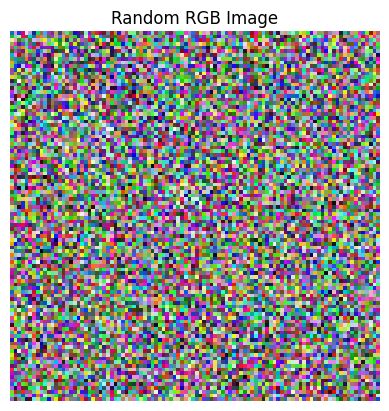

In [13]:
import numpy as np
import matplotlib.pyplot as plt

# Create a random RGB image
rgb_image = np.random.randint(0, 256, (100, 100, 3), dtype=np.uint8)

# Display the RGB image
plt.imshow(rgb_image)
plt.title('Random RGB Image')
plt.axis('off')  # Hide the axis
plt.show()

# Covid

In [14]:
# covid_config = {
#     'encoder': {
#         'image_size': (299, 299),
#         'patch_size': 23,
#         'd_model': 192,
#         'n_heads': 8,
#         'd_ff': 128,
#         'n_layers': 12,
#         'distilled': False,
#         'channels': 1,
#     },
#     'decoder': {
#         'drop_path_rate': 0.0,
#         'dropout': 0.1,
#         'n_layers': 2,
#     },
# }

# covid_dm = SegDM(
#     batch_size=4,
#     img_dir='/kaggle/input/img-segmentation/Covid19 Radiography/COVID-19_Radiography_Dataset/COVID/images',
#     mask_dir='/kaggle/input/img-segmentation/Covid19 Radiography/COVID-19_Radiography_Dataset/COVID/masks',
# )
# covid_logger = CSVLogger("logs", name=f"covid", flush_logs_every_n_steps=1)
# covid_model = SegmenterModule(covid_config, num_classes=2)
# covid_trainer = L.Trainer(fast_dev_run=True, logger=covid_logger, max_epochs=10)
# covid_trainer.fit(covid_model, covid_dm)
# covid_trainer.test(covid_model, covid_dm)